In [1]:
# Tree-Based Models for Wildfire Burned Area (FIRE_SIZE)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# For nicer printing
pd.set_option("display.max_columns", 50)

In [2]:
df = pd.read_csv("wildfires_greather_than_100acres_with_temperature.xls")

# Define target and predictors
year_col   = "FIRE_YEAR"      # year of fire
target_col = "FIRE_SIZE"      # burned area (acres)

feature_cols = [
    "LATITUDE",
    "LONGITUDE",
    "DISCOVERY_DOY",  # day of year (numeric)
    "TMAX",           # max temperature
]

# Keep only rows with complete data in these columns
df_model = df[[year_col, target_col] + feature_cols].dropna().copy()

print("Shape after dropna:", df_model.shape)
df_model.head()


Shape after dropna: (12822, 6)


,FIRE_YEAR,FIRE_SIZE,LATITUDE,LONGITUDE,DISCOVERY_DOY,TMAX
0,2004,16823.0,38.523333,-120.211667,280,21.3
1,2004,7700.0,38.780000,-120.260000,287,24.7
2,2005,125.0,36.001667,-81.590000,43,10.5
3,2005,119.0,43.899167,-102.954722,197,40.1
4,2005,119.0,43.892778,-102.948056,197,39.7


In [3]:
# Train = 1992–2015, Test = 2016–2020
train_mask = (df_model[year_col] >= 1992) & (df_model[year_col] <= 2015)
test_mask  = (df_model[year_col] >= 2016) & (df_model[year_col] <= 2020)

train_df = df_model.loc[train_mask].copy()
test_df  = df_model.loc[test_mask].copy()

X_train = train_df[feature_cols].values
y_train = train_df[target_col].values

X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)

Train shape: (10447, 6)
Test  shape: (2375, 6)


In [4]:
# Spatial blocking: north (1) vs south (0) using median latitude
lat_median = train_df["LATITUDE"].median()
train_df["region_block"] = np.where(train_df["LATITUDE"] >= lat_median, 1, 0)

# Temporal blocking within training years (≈ early / mid / late)
train_df["time_block"] = pd.qcut(
    train_df[year_col],
    q=3,
    labels=False,
    duplicates="drop"
)

# Spatiotemporal block ID = combination of region and time block
train_df["block_id"] = (
    train_df["region_block"].astype(int) * 10
    + train_df["time_block"].astype(int)
)

groups = train_df["block_id"].values
logo = LeaveOneGroupOut()

print("Training samples:", X_train.shape[0])
print("Test samples:    ", X_test.shape[0])
print("Latitude median for north/south split:", lat_median)
print("Unique spatiotemporal blocks (train):", np.unique(groups))

Training samples: 10447
Test samples:     2375
Latitude median for north/south split: 38.83666667
Unique spatiotemporal blocks (train): [ 0  1  2 10 11 12]


In [6]:
def evaluate_regression(model, X_train, y_train, X_test, y_test, model_name="model"):
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)
    
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test  = mean_squared_error(y_test, y_pred_test, squared=False)
    mae_test   = mean_absolute_error(y_test, y_pred_test)
    r2_train   = r2_score(y_train, y_pred_train)
    r2_test    = r2_score(y_test, y_pred_test)
    
    print(f"\n=== {model_name} ===")
    print(f"Train RMSE: {rmse_train:,.2f}")
    print(f"Test  RMSE: {rmse_test:,.2f}")
    print(f"Test  MAE:  {mae_test:,.2f}")
    print(f"Train R^2: {r2_train:,.3f}")
    print(f"Test  R^2: {r2_test:,.3f}")
    
    return {
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "r2_train": r2_train,
        "r2_test": r2_test,
    }

In [7]:
# Base decision tree regressor
tree = DecisionTreeRegressor(random_state=0)

# Hyperparameter grid
tree_param_grid = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_leaf": [1, 5, 10, 20],
}

# Grid search with LOGO CV and blocked groups
tree_grid = GridSearchCV(
    estimator=tree,
    param_grid=tree_param_grid,
    cv=logo,
    scoring="neg_mean_squared_error",  # we will take sqrt to get RMSE
    n_jobs=-1,
    verbose=1,
)

tree_grid.fit(X_train, y_train, groups=groups)

best_tree = tree_grid.best_estimator_
best_tree_params = tree_grid.best_params_
best_tree_rmse_cv = (-tree_grid.best_score_) ** 0.5

print("\n=== Decision Tree (GridSearchCV) ===")
print("Best params:", best_tree_params)
print(f"Best CV RMSE (LOGO): {best_tree_rmse_cv:,.2f}")

tree_results = evaluate_regression(
    best_tree, X_train, y_train, X_test, y_test,
    model_name="Decision Tree"
)


Fitting 6 folds for each of 20 candidates, totalling 120 fits

=== Decision Tree (GridSearchCV) ===
Best params: {'max_depth': 3, 'min_samples_leaf': 20}
Best CV RMSE (LOGO): 16,164.76

=== Decision Tree ===
Train RMSE: 15,611.68
Test  RMSE: 28,027.37
Test  MAE:  7,323.35
Train R^2: 0.044
Test  R^2: -0.026


C:\Users\Popey\.conda\envs\tf_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Popey\.conda\envs\tf_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


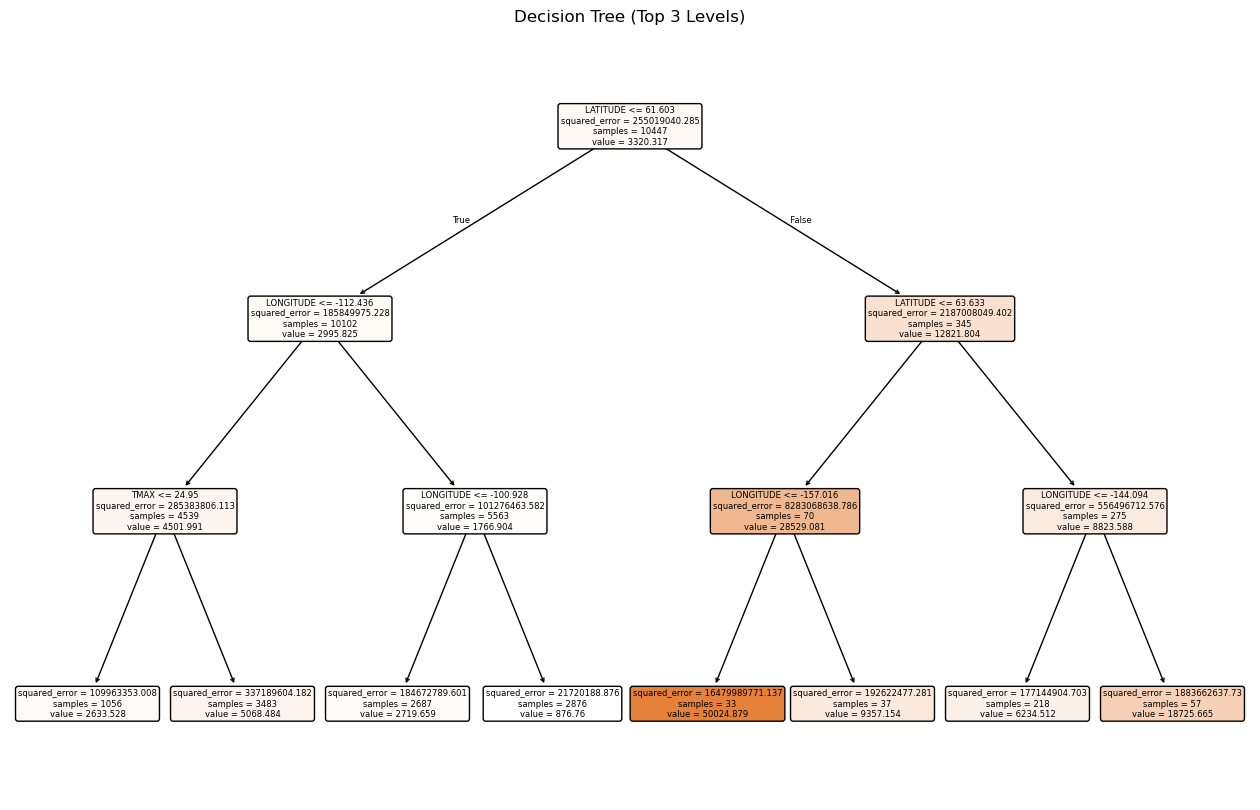

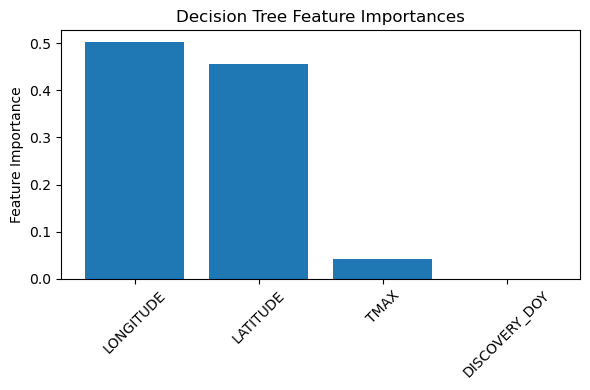

In [8]:
# Plot top levels of the best decision tree (full tree might be huge)
plt.figure(figsize=(16, 10))
plot_tree(
    best_tree,
    feature_names=feature_cols,
    filled=True,
    rounded=True,
    max_depth=3  # show only first 3 levels for readability
)
plt.title("Decision Tree (Top 3 Levels)")
plt.show()

# Feature importances
tree_importances = best_tree.feature_importances_
sorted_idx = np.argsort(tree_importances)[::-1]

plt.figure(figsize=(6, 4))
plt.bar(range(len(feature_cols)), tree_importances[sorted_idx])
plt.xticks(range(len(feature_cols)),
           np.array(feature_cols)[sorted_idx],
           rotation=45)
plt.ylabel("Feature Importance")
plt.title("Decision Tree Feature Importances")
plt.tight_layout()
plt.show()


In [9]:
rf = RandomForestRegressor(
    random_state=0,
    n_jobs=-1
)

rf_param_grid = {
    "n_estimators": [200, 500],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 5, 10],
    "max_features": [1, 2, 4],  # number of features to consider at each split
}

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=logo,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

rf_grid.fit(X_train, y_train, groups=groups)

best_rf = rf_grid.best_estimator_
best_rf_params = rf_grid.best_params_
best_rf_rmse_cv = (-rf_grid.best_score_) ** 0.5

print("\n=== Random Forest (GridSearchCV) ===")
print("Best params:", best_rf_params)
print(f"Best CV RMSE (LOGO): {best_rf_rmse_cv:,.2f}")

rf_results = evaluate_regression(
    best_rf, X_train, y_train, X_test, y_test,
    model_name="Random Forest"
)


Fitting 6 folds for each of 54 candidates, totalling 324 fits

=== Random Forest (GridSearchCV) ===
Best params: {'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 10, 'n_estimators': 500}
Best CV RMSE (LOGO): 15,607.03

=== Random Forest ===
Train RMSE: 14,819.02
Test  RMSE: 27,716.54
Test  MAE:  7,133.85
Train R^2: 0.139
Test  R^2: -0.003


C:\Users\Popey\.conda\envs\tf_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Popey\.conda\envs\tf_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


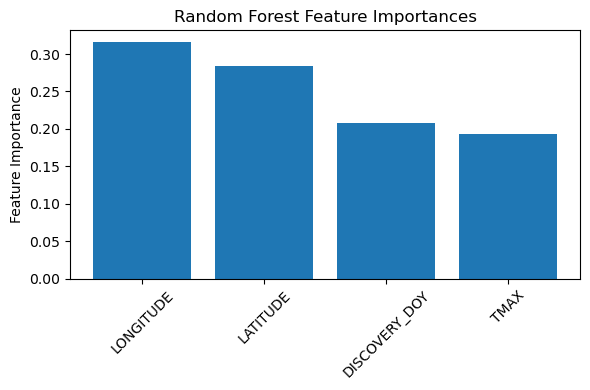

In [10]:
rf_importances = best_rf.feature_importances_
sorted_idx = np.argsort(rf_importances)[::-1]

plt.figure(figsize=(6, 4))
plt.bar(range(len(feature_cols)), rf_importances[sorted_idx])
plt.xticks(range(len(feature_cols)),
           np.array(feature_cols)[sorted_idx],
           rotation=45)
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

In [11]:
gbr = GradientBoostingRegressor(random_state=0)

gbr_param_grid = {
    "n_estimators": [100, 300],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5],
    "min_samples_leaf": [1, 5],
}

gbr_grid = GridSearchCV(
    estimator=gbr,
    param_grid=gbr_param_grid,
    cv=logo,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)

gbr_grid.fit(X_train, y_train, groups=groups)

best_gbr = gbr_grid.best_estimator_
best_gbr_params = gbr_grid.best_params_
best_gbr_rmse_cv = (-gbr_grid.best_score_) ** 0.5

print("\n=== Gradient Boosting (GridSearchCV) ===")
print("Best params:", best_gbr_params)
print(f"Best CV RMSE (LOGO): {best_gbr_rmse_cv:,.2f}")

gbr_results = evaluate_regression(
    best_gbr, X_train, y_train, X_test, y_test,
    model_name="Gradient Boosting"
)

Fitting 6 folds for each of 16 candidates, totalling 96 fits

=== Gradient Boosting (GridSearchCV) ===
Best params: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 5, 'n_estimators': 100}
Best CV RMSE (LOGO): 16,998.40

=== Gradient Boosting ===
Train RMSE: 14,793.40
Test  RMSE: 27,992.02
Test  MAE:  7,193.23
Train R^2: 0.142
Test  R^2: -0.023


C:\Users\Popey\.conda\envs\tf_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Popey\.conda\envs\tf_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


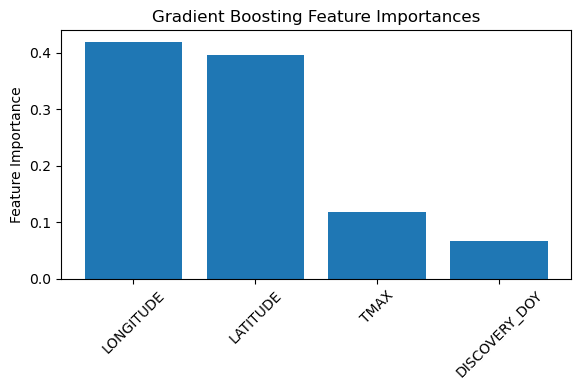

In [12]:
gbr_importances = best_gbr.feature_importances_
sorted_idx = np.argsort(gbr_importances)[::-1]

plt.figure(figsize=(6, 4))
plt.bar(range(len(feature_cols)), gbr_importances[sorted_idx])
plt.xticks(range(len(feature_cols)),
           np.array(feature_cols)[sorted_idx],
           rotation=45)
plt.ylabel("Feature Importance")
plt.title("Gradient Boosting Feature Importances")
plt.tight_layout()
plt.show()

In [13]:
summary = pd.DataFrame({
    "Model": ["Decision Tree", "Random Forest", "Gradient Boosting"],
    "Train_RMSE": [tree_results["rmse_train"],
                   rf_results["rmse_train"],
                   gbr_results["rmse_train"]],
    "Test_RMSE": [tree_results["rmse_test"],
                  rf_results["rmse_test"],
                  gbr_results["rmse_test"]],
    "Test_MAE": [tree_results["mae_test"],
                 rf_results["mae_test"],
                 gbr_results["mae_test"]],
    "Train_R2": [tree_results["r2_train"],
                 rf_results["r2_train"],
                 gbr_results["r2_train"]],
    "Test_R2": [tree_results["r2_test"],
                rf_results["r2_test"],
                gbr_results["r2_test"]],
})

summary

,Model,Train_RMSE,Test_RMSE,Test_MAE,Train_R2,Test_R2
0,Decision Tree,15611.675081,28027.369525,7323.347979,0.044289,-0.025566
1,Random Forest,14819.021463,27716.539326,7133.845202,0.138875,-0.002945
2,Gradient Boosting,14793.402989,27992.019320,7193.232529,0.141849,-0.022981
